# **Import Libraries.**

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
image_size = 224

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [4]:
train_data = train_datagen.flow_from_directory(os.path.join(base_dir,"train"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 70295 images belonging to 38 classes.


In [5]:
test_data = test_datagen.flow_from_directory(os.path.join(base_dir,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 17572 images belonging to 38 classes.


In [6]:
train_data.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [7]:
train_data.image_shape

(224, 224, 3)

#  **Using MobileNet**

In [8]:
# weights="imagenet"(load weights pretrained on the ImageNet)
# include_top=False (Do not include the ImageNet classifier at the top)

base_model = keras.applications.MobileNet(weights="../input/tf-keras-pretrained-model-weights/No Top/mobilenet_1_0_192_tf_no_top.h5",
                                          input_shape=(224,224,3),
                                          include_top=False,)

In [9]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [10]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense((38),activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name='leaf_disease_model_mobilenet')
mobilenet_model.summary()

Model: "leaf_disease_model_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                38950     
Total params: 3,267,814
Trainable params: 38,950
Non-trainable params: 3,228,864
_________________________________________________________________


# **Compile and train the model.**

In [11]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()])

In [12]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import EarlyStopping

# EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1)

callbacks_list = [early_stop]

history = mobilenet_model.fit(train_data,
                              steps_per_epoch=300,  
                              validation_data=test_data,
                              epochs=18,
                              validation_steps=300,
                              callbacks=callbacks_list)


Epoch 1/18
300/300 [==============================] - 525s 2s/step - loss: 3.2804 - categorical_accuracy: 0.4616 - val_loss: 3.0664 - val_categorical_accuracy: 0.6557
Epoch 2/18
300/300 [==============================] - 518s 2s/step - loss: 3.0123 - categorical_accuracy: 0.7156 - val_loss: 2.9208 - val_categorical_accuracy: 0.7934
Epoch 3/18
300/300 [==============================] - 512s 2s/step - loss: 2.9225 - categorical_accuracy: 0.7939 - val_loss: 2.8771 - val_categorical_accuracy: 0.8334
Epoch 4/18
300/300 [==============================] - 514s 2s/step - loss: 2.8904 - categorical_accuracy: 0.8240 - val_loss: 2.8527 - val_categorical_accuracy: 0.8529
Epoch 5/18
300/300 [==============================] - 509s 2s/step - loss: 2.8642 - categorical_accuracy: 0.8428 - val_loss: 2.8485 - val_categorical_accuracy: 0.8505
Epoch 6/18
300/300 [==============================] - 508s 2s/step - loss: 2.8539 - categorical_accuracy: 0.8524 - val_loss: 2.8428 - val_categorical_accuracy: 0.858

# **Evaluate Model.**

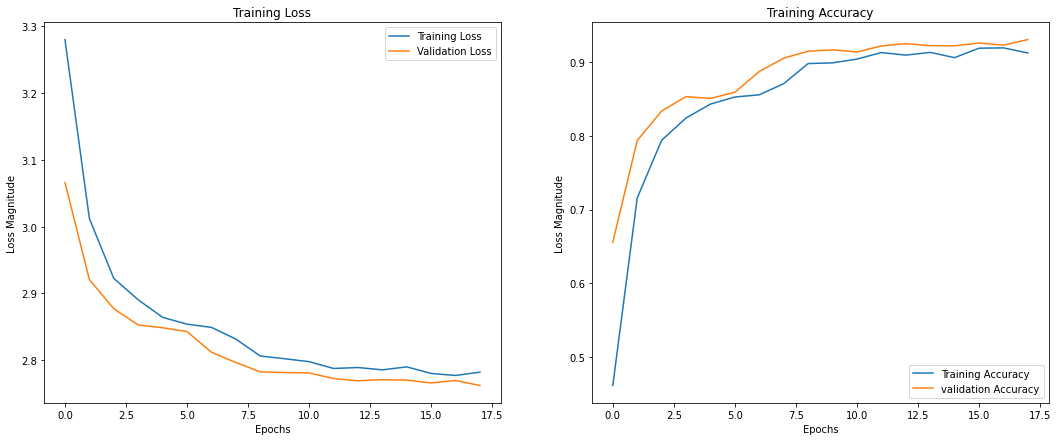

In [13]:
# Learning Curves.
# Plot Loss vs Accuracy graphs.

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation Accuracy')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Accuracy')
plt.legend(loc='lower right')
plt.show()

# **Predictions.**

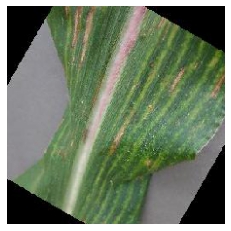

True label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Predicted label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


In [14]:
def get_class_string_from_index(index):
   for class_string, class_index in test_data.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_data)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = mobilenet_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))